# Vision Trials

This notebooks contains code to use pure computer vision algorithms without deep learning to classify thermal images

## Rule-based thermal hotspot detection (legend-aware)

We detect high-temperature spots (red) in HSV while masking legend areas (color bars) anywhere in the image.
- Build a red mask in HSV (two ranges due to hue wraparound).
- Detect legend regions via high-saturation elongated rectangles (vertical/horizontal) with multi-hue progression; search across the whole image.
- Remove legend from the red mask, clean small blobs, and classify as Faulty if a significant hotspot remains away from edges.

Tune thresholds if colormap differs (e.g., saturation/value cutoffs, elongation factors, or hue-bin checks).

In [45]:
import cv2 as cv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

Create helper functions

In [ ]:
def ensure_bgr(img):
    """Ensure the input image is in BGR format.
    args:
        img: Input image (numpy array).
    returns:
        The image in BGR format (numpy array), or None if input is None.
    """
    if img is None:
        return None
    if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
        return cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    return img

def make_red_mask_hsv(img_bgr):
    """Return a binary mask of red regions in the input BGR image.
    args:
        img_bgr: Input image in BGR color space (numpy array).
    returns:
        A binary mask (numpy array) where red regions are white (255) and other regions are black (0).
    """
    hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
    lower_red1 = np.array([0, 120, 80], dtype=np.uint8)
    upper_red1 = np.array([10, 255, 255], dtype=np.uint8)
    lower_red2 = np.array([170, 120, 80], dtype=np.uint8)
    upper_red2 = np.array([179, 255, 255], dtype=np.uint8)
    mask1 = cv.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv.inRange(hsv, lower_red2, upper_red2)
    mask = cv.bitwise_or(mask1, mask2)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations=1)
    return mask

def detect_legend_mask(img_bgr):
    """
    Return a binary mask of legend regions in the input BGR image. Legends are detected as high-saturation tall/narrow rectangles
    args:
        img_bgr: Input image in BGR color space (numpy array).
    returns:
        A binary mask (numpy array) where legend regions are white (255) and other regions are black (0).
    """
    h, w = img_bgr.shape[:2]
    hsv = cv.cvtColor(img_bgr, cv.COLOR_BGR2HSV)
    s = hsv[:, :, 1]
    sat_mask = cv.inRange(s, 100, 255)
    vert_kernel = cv.getStructuringElement(cv.MORPH_RECT, (max(2, w // 100), max(10, h // 20)))
    sat_vert = cv.morphologyEx(sat_mask, cv.MORPH_CLOSE, vert_kernel, iterations=1)
    contours, _ = cv.findContours(sat_vert, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    legend_mask = np.zeros((h, w), dtype=np.uint8)
    for cnt in contours:
        x, y, ww, hh = cv.boundingRect(cnt)
        aspect = hh / max(1, ww)
        area = ww * hh
        is_tall_bar = (ww < 0.22 * w and aspect > 3.5)
        is_large_enough = (area > 0.01 * w * h)
        near_edge = (x > 0.65 * w) or (y > 0.65 * h)
        if (is_tall_bar and is_large_enough and near_edge) or (hh < 0.15 * h and ww > 0.4 * w and y > 0.7 * h):
            cv.rectangle(legend_mask, (x, y), (x + ww, y + hh), 255, -1)
    right_strip = int(0.12 * w)
    bottom_strip = int(0.12 * h)
    legend_mask[:, w - right_strip:] = 255
    legend_mask[h - bottom_strip:, :] = 255
    return legend_mask

def remove_small_components(mask, min_area):
    """
    Remove small connected components from the binary mask.
    args:
        mask: Input binary mask (numpy array).
        min_area: Minimum area threshold for components to keep.
    returns:
        A binary mask (numpy array) with small components removed.
    """
    num_labels, labels, stats, _ = cv.connectedComponentsWithStats(mask, connectivity=8)
    out = np.zeros_like(mask)
    for i in range(1, num_labels):
        area = stats[i, cv.CC_STAT_AREA]
        if area >= min_area:
            out[labels == i] = 255
    return out

Main classification algorithm

In [ ]:
def classify_thermal_image_cv(image_path, debug=False):
    """
    Legend-aware rule-based classifier: returns 'Faulty' if a significant hotspot remains
    after removing likely legend areas; else 'Normal'.
    args:
        image_path: Path to the input image file (string or Path).
        debug: If True, returns additional debug information.
    returns:
        'Faulty' or 'Normal' label (string). If debug=True, also returns
    """
    img = cv.imread(image_path, cv.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Cannot read {image_path}")
    img = ensure_bgr(img)
    h, w = img.shape[:2]

    red_mask = make_red_mask_hsv(img)
    legend_mask = detect_legend_mask(img)
    red_mask_nolegend = cv.bitwise_and(red_mask, cv.bitwise_not(legend_mask))
    red_mask_nolegend = cv.morphologyEx(red_mask_nolegend, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5)), iterations=1)
    red_mask_nolegend = remove_small_components(red_mask_nolegend, min_area=max(20, int(0.001 * h * w)))

    contours, _ = cv.findContours(red_mask_nolegend, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    faulty = False
    for cnt in contours:
        area = cv.contourArea(cnt)
        if area < max(20, 0.001 * h * w):
            continue
        x, y, ww, hh = cv.boundingRect(cnt)
        if hh / max(1, ww) > 6 and ww < 0.1 * w:
            continue
        M = cv.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        if cx < 0.05 * w or cx > 0.95 * w or cy < 0.05 * h or cy > 0.95 * h:
            continue
        faulty = True
        break

    label = "Faulty" if faulty else "Normal"
    if debug:
        overlay = img.copy()
        cv.drawContours(overlay, contours, -1, (0, 255, 0), 2)
        vis = cv.addWeighted(overlay, 0.7, cv.cvtColor(red_mask_nolegend, cv.COLOR_GRAY2BGR), 0.3, 0)
        return label, red_mask, legend_mask, red_mask_nolegend, vis
    return label

In [50]:
def classify_folder(folder_glob_pattern):
    """Classify all thermal images in a folder.
    args:
        folder_glob_pattern: Glob pattern to match image files (string).
    returns:
        A dictionary with counts of 'Faulty', 'Normal', and 'Total' images.
    """
    paths = [str(p) for p in Path().glob(folder_glob_pattern)]
    results = {"Faulty": 0, "Normal": 0, "Total": 0}
    for p in paths:
        try:
            label = classify_thermal_image_cv(p, debug=False)
            results[label] += 1
            results["Total"] += 1
            results["list"] = results.get("list", []) + [label]
            results["paths"] = results.get("paths", []) + [p]
        except Exception as e:
            pass
    return results

In [52]:
results_faulty = classify_folder('separated_data/faulty/*.*')
results_normal = classify_folder('separated_data/normal/*.*')
print(results_faulty)
print(results_normal)

{'Faulty': 36, 'Normal': 20, 'Total': 56, 'list': ['Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Faulty', 'Normal', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty', 'Faulty'], 'paths': ['separated_data\\faulty\\T1_faulty_001.jpg', 'separated_data\\faulty\\T1_faulty_002.jpg', 'separated_data\\faulty\\T1_faulty_003.jpg', 'separated_data\\faulty\\T1_faulty_004.jpg', 'separated_data\\faulty\\T1_faulty_005.jpg', 'separated_data\\faulty\\T1_faulty_006.jpg', 'separated_data\\faulty\\T1_faulty_007.jpg', 'separated_data\\faulty\\T1_faulty_008.jpg', 'separated_data\\f

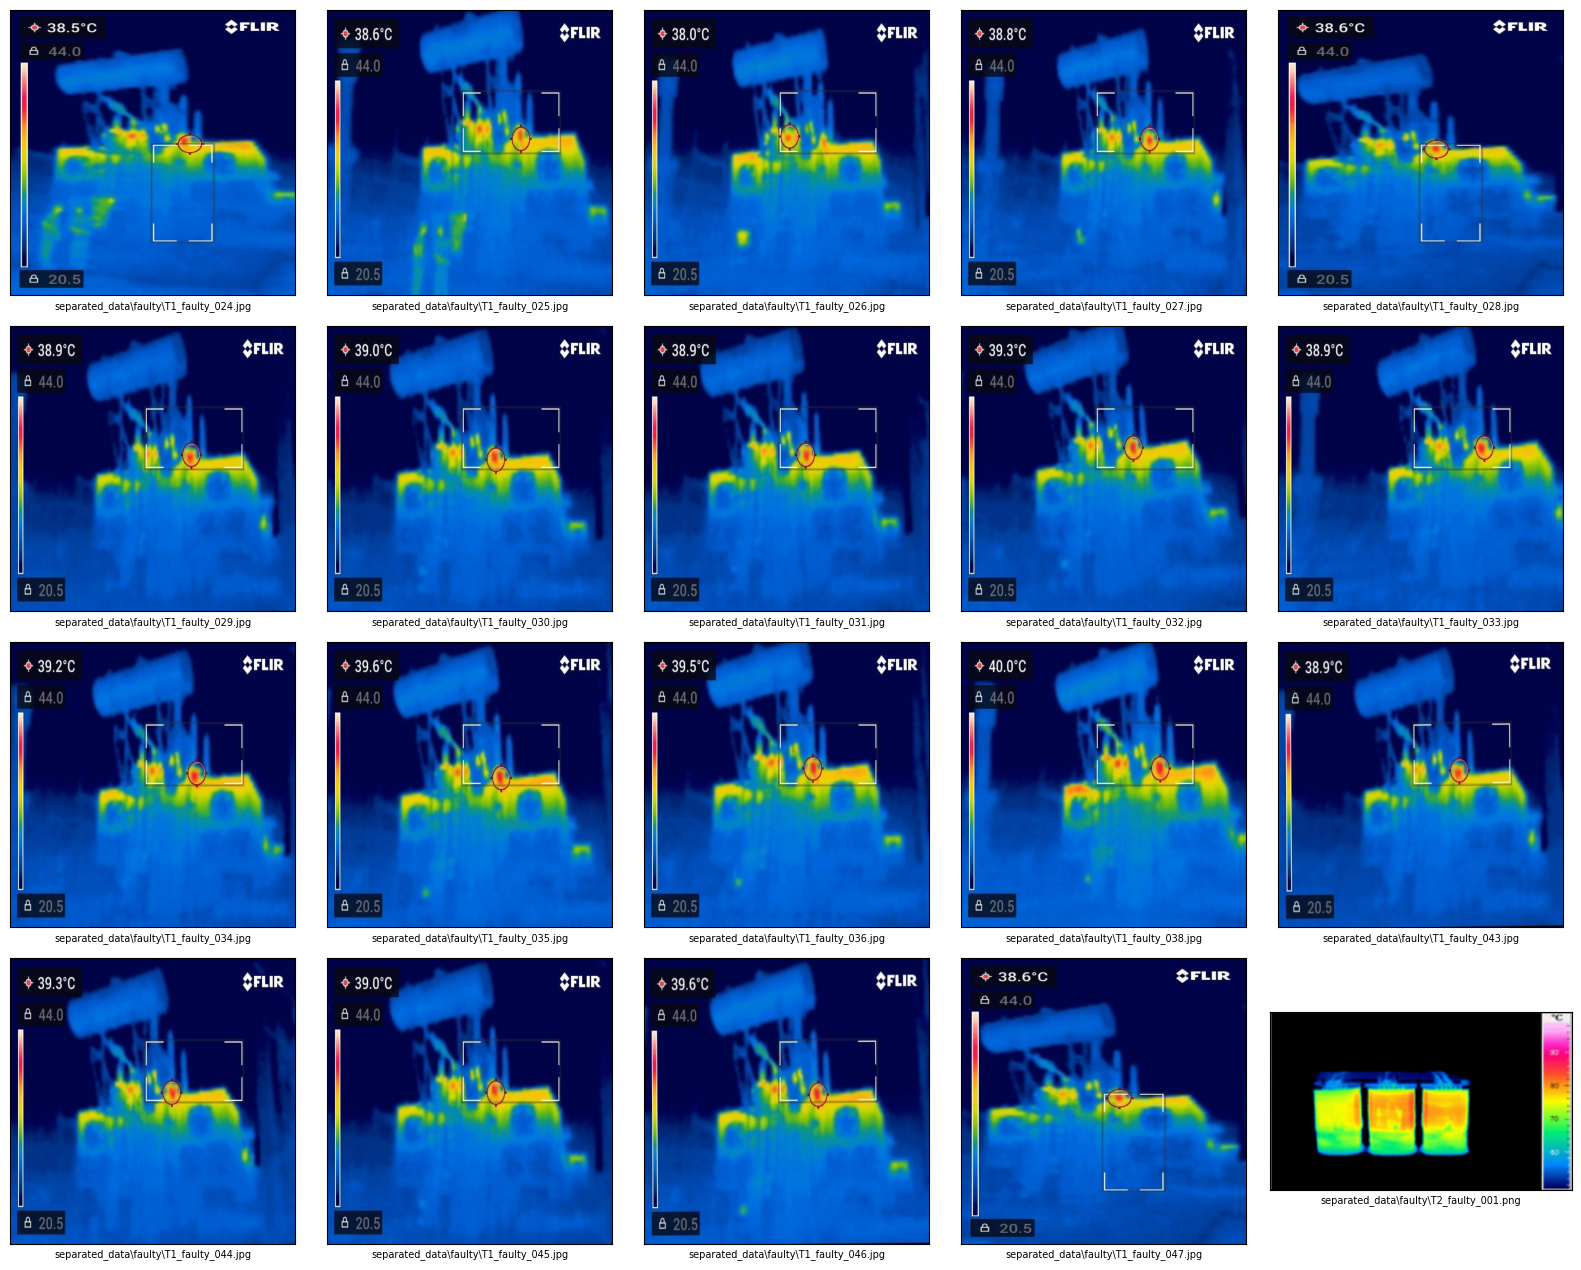

In [55]:
mis_idx = [i for i, res in enumerate(results_faulty.get("list", [])) if res != "Faulty"]
N = min(20, len(mis_idx))
if N == 0:
    print("No misclassified images to display from results_faulty.")
else:
    cols = 5
    rows = (N + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3.2, rows * 3.2))
    if rows * cols == 1:
        axes = np.array([axes])
    axes = axes.ravel()
    
    def shorten_path(p, max_len=70):
        return p if len(p) <= max_len else ("…" + p[-(max_len-1):])
    
    for j in range(rows * cols):
        ax = axes[j]
        if j < N:
            idx = mis_idx[j]
            p = results_faulty["paths"][idx]
            img = cv.imread(p)
            if img is not None:
                rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                ax.imshow(rgb)
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_xlabel(shorten_path(p), fontsize=7)
        else:
            ax.axis('off')
    plt.tight_layout()
    plt.show()